In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
import lasagne as L

from IPython import display

from util import *
from rosenbrock import RosenbrockFunction_Tensor

%load_ext autoreload
%autoreload 2

Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)


In [2]:
%run ../lstm_optimizer_params.py
%run ../ntm_bfgs_optimizer_params.py
%run ../chain_optimizer.py

In [3]:
a_sym = T.vector('A')
b_sym = T.vector('B')

func = lambda theta_sym, a_sym, b_sym: RosenbrockFunction_Tensor(theta_sym, a_sym, b_sym).func

In [4]:
options = {
    'num_units': 20,
    'function': func,
    'n_layers': 2,
    'preprocess_input': False,
    'gradient_steps': 20,
    'gradient_clipping': 1,
    'loglr': True,
}

In [5]:
def sample_point(ndim=2, *args):
    return np.zeros(2)

def sample_point_second_phase(ndim=2, a=None, b=None):
    return np.array([a, a**2]) + 0.01 * np.random.uniform(low=-1, high=1, size=2)

def sample_params(ndim=None, *args):
    a = np.random.uniform(low=-3, high=3)
    b = np.random.uniform(20, 100)
    return a, b

def sample_point_and_params(ndim=None, sample_point=sample_point):#_second_phase):
    a, b = sample_params(ndim)
    theta = sample_point(ndim, a, b)
    
    return theta, (a, b)

def grid_sampler(low, high, num=100):
    d = (high - low) / num
    x = np.linspace(low, high, num)
    y = np.linspace(low, high, num)
    xv, yv = np.meshgrid(x, y)
    return [(np.array([xv[i, j], yv[i, j]]), sample_params()) for i in range(num) for j in range(num)]

def grid_sampler_2(n_functions, dx, dy, num=100):
    problems = []
    for _ in range(n_functions):
        a, b = sample_params()
        x = np.linspace(a - dx, a + dx, num)
        y = np.linspace(a**2 - dy, a**2 + dy, num)
        xv, yv = np.meshgrid(x, y)
        problems += [(np.array([xv[i, j], yv[i, j]]), a, b) for i in range(num) for j in range(num)]
    return list(map(np.array, zip(*problems)))

def multisampler(n, *args):
    A = np.random.uniform(low=-3, high=3, size=n)
    B = np.random.uniform(20, 100, size=n)
    theta = np.zeros((n, 2))
    return theta, A, B

In [6]:
options['n_gac'] = 0
n_opt = 7

opts = [LSTM_Optimizer(scale_output=2**(-i), params_input=[a_sym, b_sym], **options) for i in range(n_opt)]
opt_intersection = ChainOptimizer(opts, n_small_steps=20)

opts = [LSTM_Optimizer(scale_output=2**(-i), params_input=[a_sym, b_sym], **options) for i in range(n_opt)]
opt_non_intersection = ChainOptimizer(opts, n_small_steps=20)

In [7]:
opt_intersection.prepare(loss_type='sum', start_lr=0.001)
opt_non_intersection.prepare(loss_type='sum', start_lr=0.001)

Time compiling value_fn: 0.2901904582977295
Time compiling loss_fn: 3.7485239505767822
Time compiling train_fn: 78.61047339439392
Time compiling value_fn: 0.10361886024475098
Time compiling loss_fn: 2.604642152786255
Time compiling train_fn: 87.26704740524292
Time compiling value_fn: 0.1044464111328125
Time compiling loss_fn: 2.736821413040161
Time compiling train_fn: 94.40121603012085
Time compiling value_fn: 0.12713885307312012
Time compiling loss_fn: 2.58074951171875
Time compiling train_fn: 91.12225532531738
Time compiling value_fn: 0.11638426780700684
Time compiling loss_fn: 2.6756539344787598
Time compiling train_fn: 89.38625502586365
Time compiling value_fn: 0.13179945945739746
Time compiling loss_fn: 2.6736347675323486
Time compiling train_fn: 94.0745849609375
Time compiling value_fn: 0.11243629455566406
Time compiling loss_fn: 2.5878841876983643
Time compiling train_fn: 88.01888251304626
Time compiling value_fn: 0.11459541320800781
Time compiling loss_fn: 8.530450344085693
Tim

In [8]:
val_inputs = multisampler(8000)

In [9]:
n_epochs   = 30
batch_size = 400

training_options = {
    'n_epochs'  : n_epochs,
    'batch_size': batch_size,
    'decay_rate': 1.0,
    'verbose': True
}

iterations = [20]
n_functions = n_epochs * batch_size

In [10]:
from rosenbrock import RosenbrockFunction

a_one_sym = T.scalar('a')
b_one_sym = T.scalar('b')
func_ = lambda theta: RosenbrockFunction(theta, a_one_sym, b_one_sym).func

sgd_fn = make_sgd(func_, var=[a_one_sym, b_one_sym])
momentum_fn = make_momentum(func_, var=[a_one_sym, b_one_sym])
lbfgs_fn = make_lbfgs(func_, m=10, init_lr=2e-4, var=[a_one_sym, b_one_sym])

non_lstm_optimizers = {
    'sgd': sgd_fn,
    'momentum': momentum_fn, 
    'lbfgs': lbfgs_fn
}

In [30]:
train_inputs = multisampler(3000)

new_partition = None

p = 0

for theta, a, b in zip(*train_inputs):
    lbfgs_thetas, lbfgs_losses = lbfgs_fn(theta, 100, a, b, 1.0)

    partition = get_partition(
        (lbfgs_thetas, 
         np.tile(a, (lbfgs_thetas.shape[0],)), 
         np.tile(b, (lbfgs_thetas.shape[0],))
        ),
        lbfgs_losses, 
        #[1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8], filter_empty=False,
        [1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10], filter_empty=False,
    )
    
    if new_partition:
        for i in range(len(new_partition)):
            for j, k in enumerate(partition[i]):
                new_partition[i][j] = np.concatenate([new_partition[i][j], k], axis=0)
    else:
        new_partition = [list(p) for p in partition]

    if p % 100 == 0:
        print(p)
    p += 1
    
    
for i in range(len(new_partition)):
    indices = np.arange(len(new_partition[i][0]))
    np.random.shuffle(indices)
    
    for j in range(len(new_partition[i])):
        new_partition[i][j] = new_partition[i][j][indices][:8000]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [31]:
for p in new_partition:
    print(p[0].shape)

(8000, 2)
(8000, 2)
(8000, 2)
(4891, 2)
(3738, 2)
(1838, 2)
(1385, 2)


In [32]:
training_options['n_iter'] = 20

losses = {}

for name, opt in [('Intersection', opt_intersection), ('Non-Intersection', opt_non_intersection)]:
    losses[name] = []
    for i in range(len(new_partition) - 1):
        opt.opts[i].lr.set_value(0.005)
        opt.opts[i].reset_network()

        if name == 'Intersection':
            train_inputs = [
                np.concatenate([new_partition[i][0], new_partition[i+1][0]], axis=0),
                np.concatenate([new_partition[i][1], new_partition[i+1][1]], axis=0),
                np.concatenate([new_partition[i][2], new_partition[i+1][2]], axis=0),
            ]
            loss, val_loss = opt.opts[i].train(tuple(train_inputs), val_inputs, **training_options)
        else:
            loss, val_loss = opt.opts[i].train(tuple(new_partition[i]), val_inputs, **training_options)
        losses[name].append((loss, val_loss))

Epoch number 0
	Time: 5.6607582569122314
	Optimizer loss: 92222.72330078122
	Median final loss: 37.112998962402344
	Validation loss: 79.87367895507812
Epoch number 1
	Time: 5.56464147567749
	Optimizer loss: 91824.43330859375
	Median final loss: 31.94310188293457
	Validation loss: 71.626923828125
Epoch number 2
	Time: 5.691012382507324
	Optimizer loss: 91516.07065234375
	Median final loss: 27.60250473022461
	Validation loss: 66.05862353515626
Epoch number 3
	Time: 5.577881574630737
	Optimizer loss: 91264.86923242189
	Median final loss: 23.90397834777832
	Validation loss: 61.901483642578135
Epoch number 4
	Time: 5.668046236038208
	Optimizer loss: 91039.79577343751
	Median final loss: 21.20766830444336
	Validation loss: 58.95159790039062
Epoch number 5
	Time: 5.717225551605225
	Optimizer loss: 90840.63536523435
	Median final loss: 18.50681495666504
	Validation loss: 57.38915283203124
Epoch number 6
	Time: 5.412580728530884
	Optimizer loss: 90644.29223242188
	Median final loss: 17.34082984

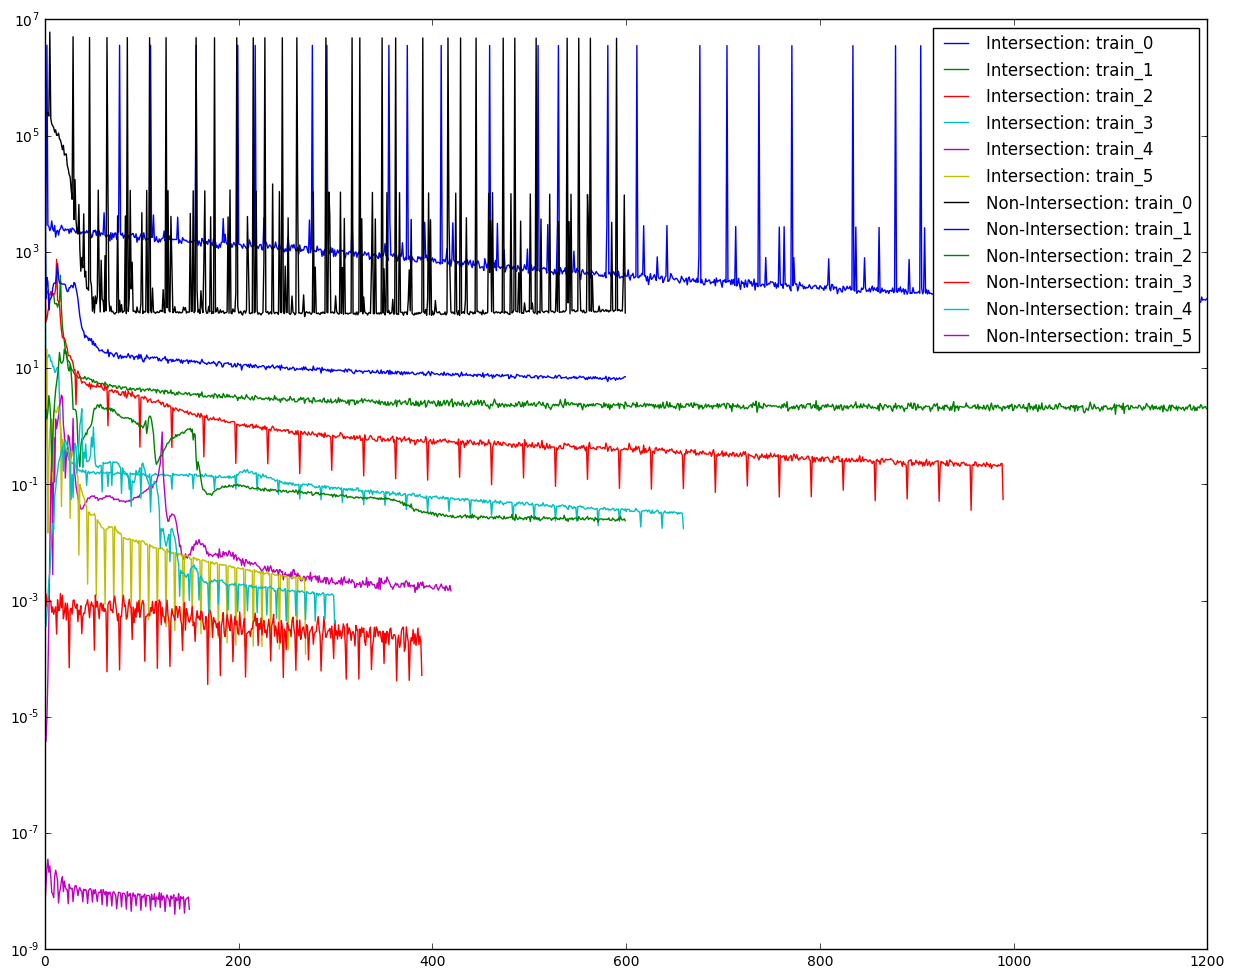

In [33]:
plt.figure(figsize=(15, 12))
for name in ['Intersection', 'Non-Intersection']:
    for k, (train_loss, val_loss) in enumerate(losses[name]):
        plt.semilogy(train_loss, label='{}: train_{}'.format(name, k))
    #     plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(k))
    plt.legend();

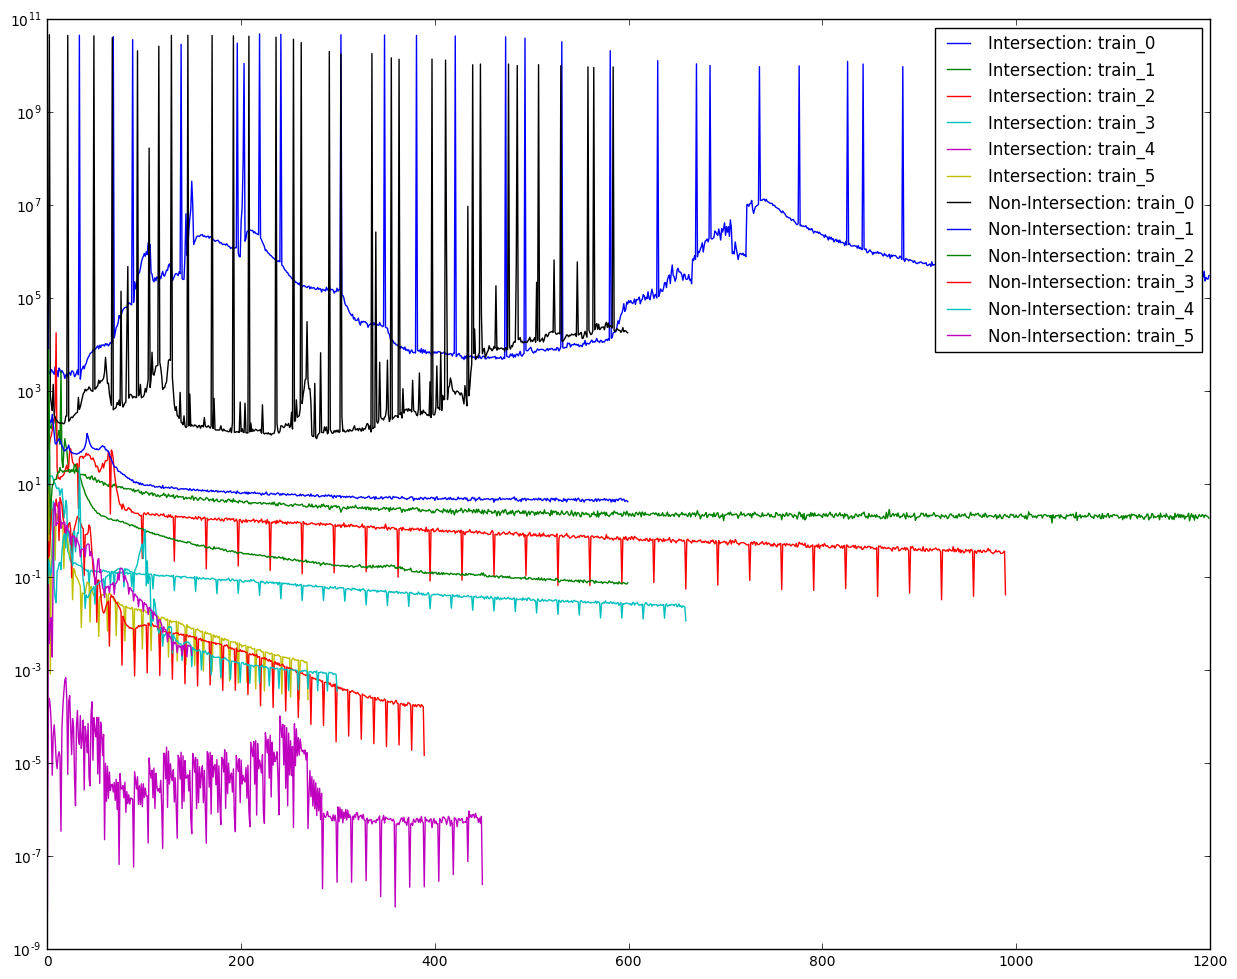

In [27]:
plt.figure(figsize=(15, 12))
for name in ['Intersection', 'Non-Intersection']:
    for k, (train_loss, val_loss) in enumerate(losses[name]):
        plt.semilogy(train_loss, label='{}: train_{}'.format(name, k))
    #     plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(k))
    plt.legend();

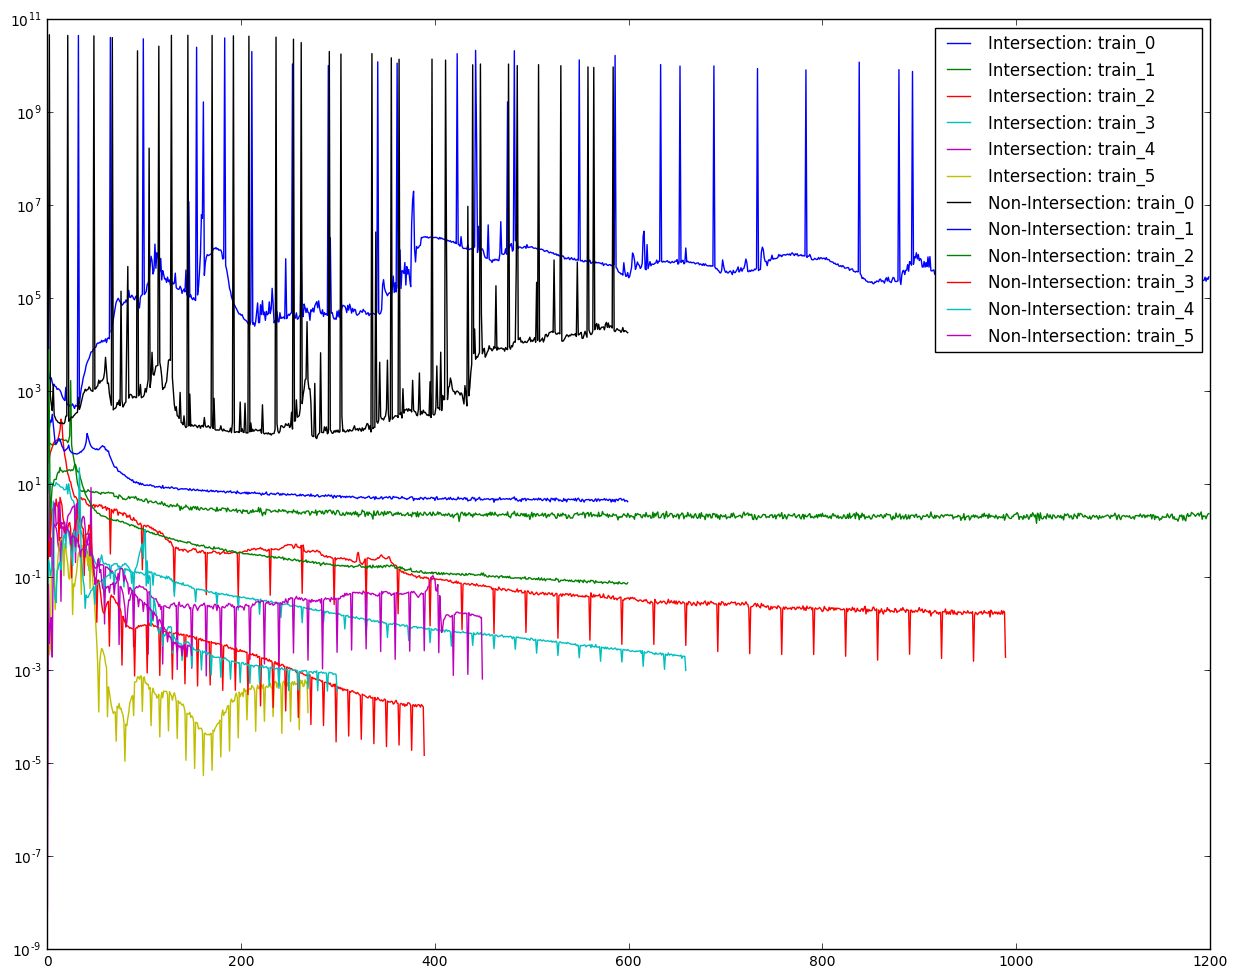

In [ ]:
plt.figure(figsize=(15, 12))
for name in ['Intersection', 'Non-Intersection']:
    for k, (train_loss, val_loss) in enumerate(losses[name]):
        plt.semilogy(train_loss, label='{}: train_{}'.format(name, k))
    #     plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(k))
    plt.legend();

In [ ]:
lstm_optimizers = {'intersection': opt_intersection, 'non-intersection': opt_non_intersection}

In [ ]:
from collections import namedtuple
TestCase = namedtuple('TestCase', 'n_iter n_functions')

In [ ]:
tests = [
    TestCase(n_iter=20, n_functions=50), 
    TestCase(n_iter=60, n_functions=50),
    TestCase(n_iter=500, n_functions=50),
    TestCase(n_iter=500, n_functions=1)
]

tests_results = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : multisampler,
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results.append(histories)

Testing lstm; non-intersection
Testing lstm; intersection
Testing lbfgs
Testing momentum
Testing sgd
Testing lstm; non-intersection
Testing lstm; intersection
Testing lbfgs
Testing momentum
Testing sgd
Testing lstm; non-intersection
Testing lstm; intersection
Testing lbfgs
Testing momentum
Testing sgd
Testing lstm; non-intersection
Testing lstm; intersection
Testing lbfgs
Testing momentum
Testing sgd


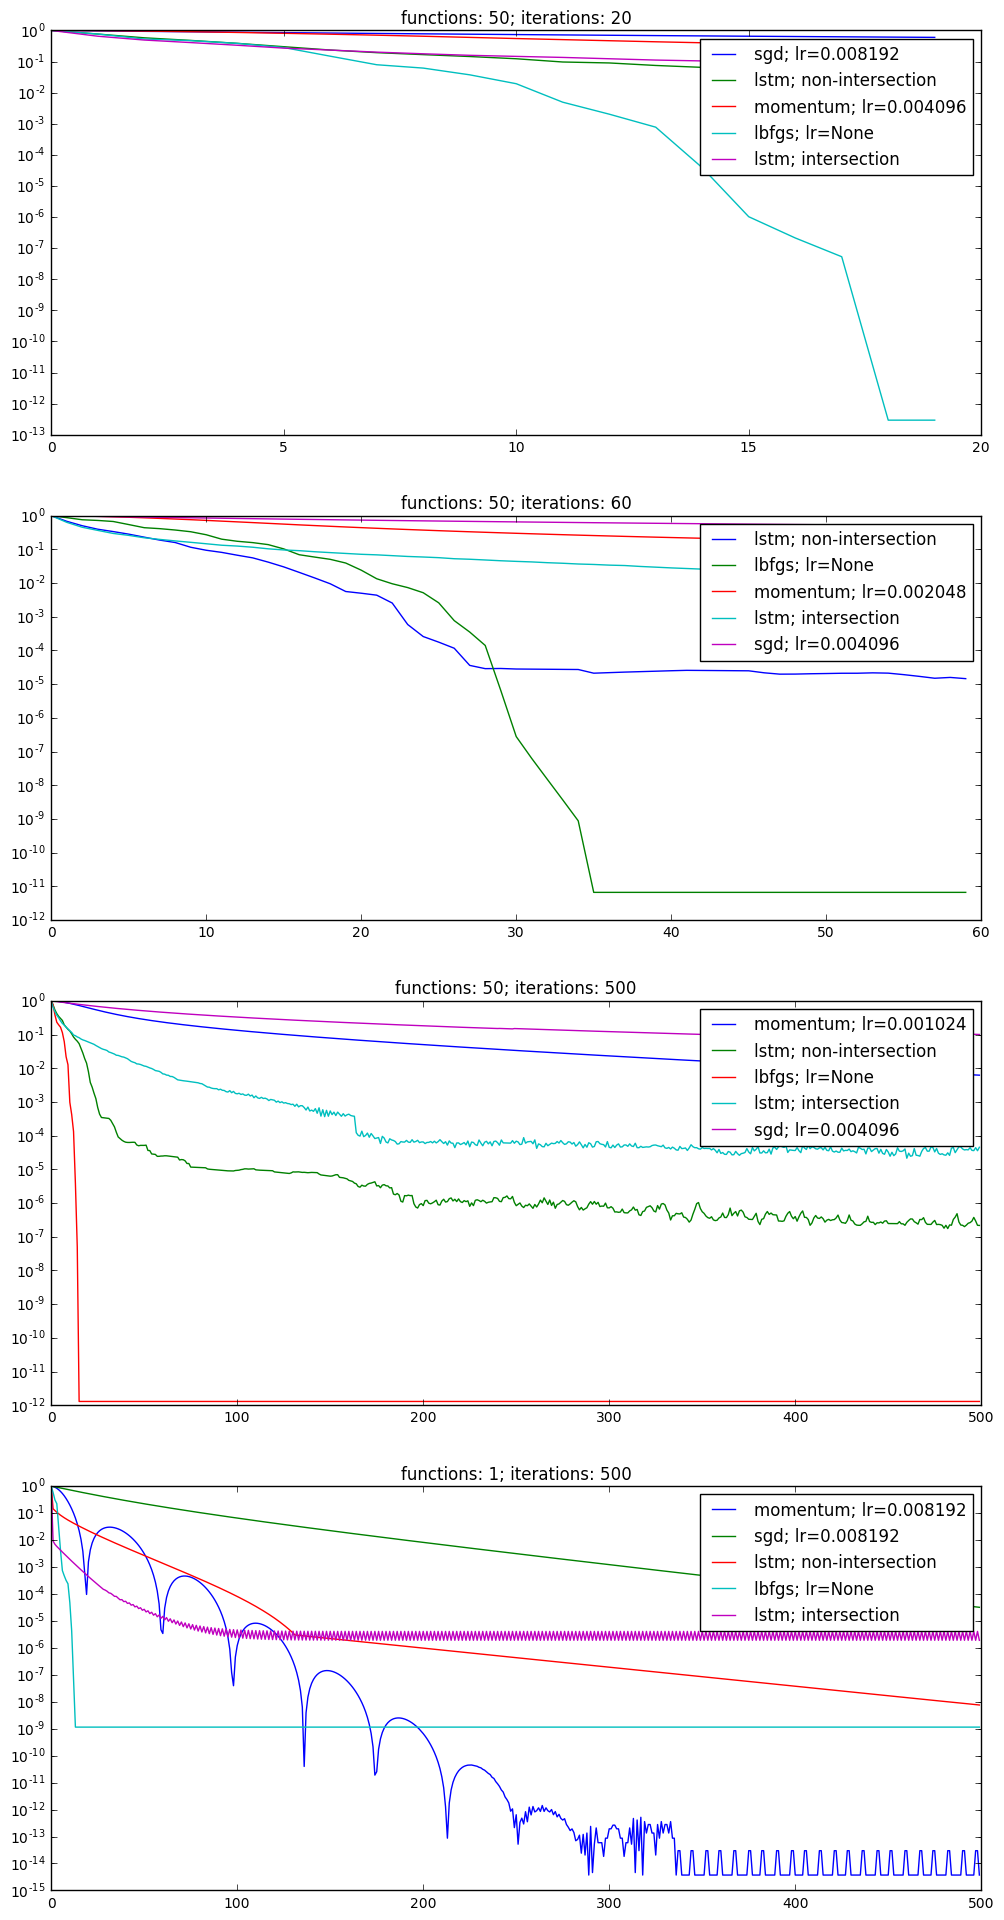

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results), figsize=(12, 6 * len(tests_results)))

if len(tests_results) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()

(1.7241951804172224, 2.972849020173978)


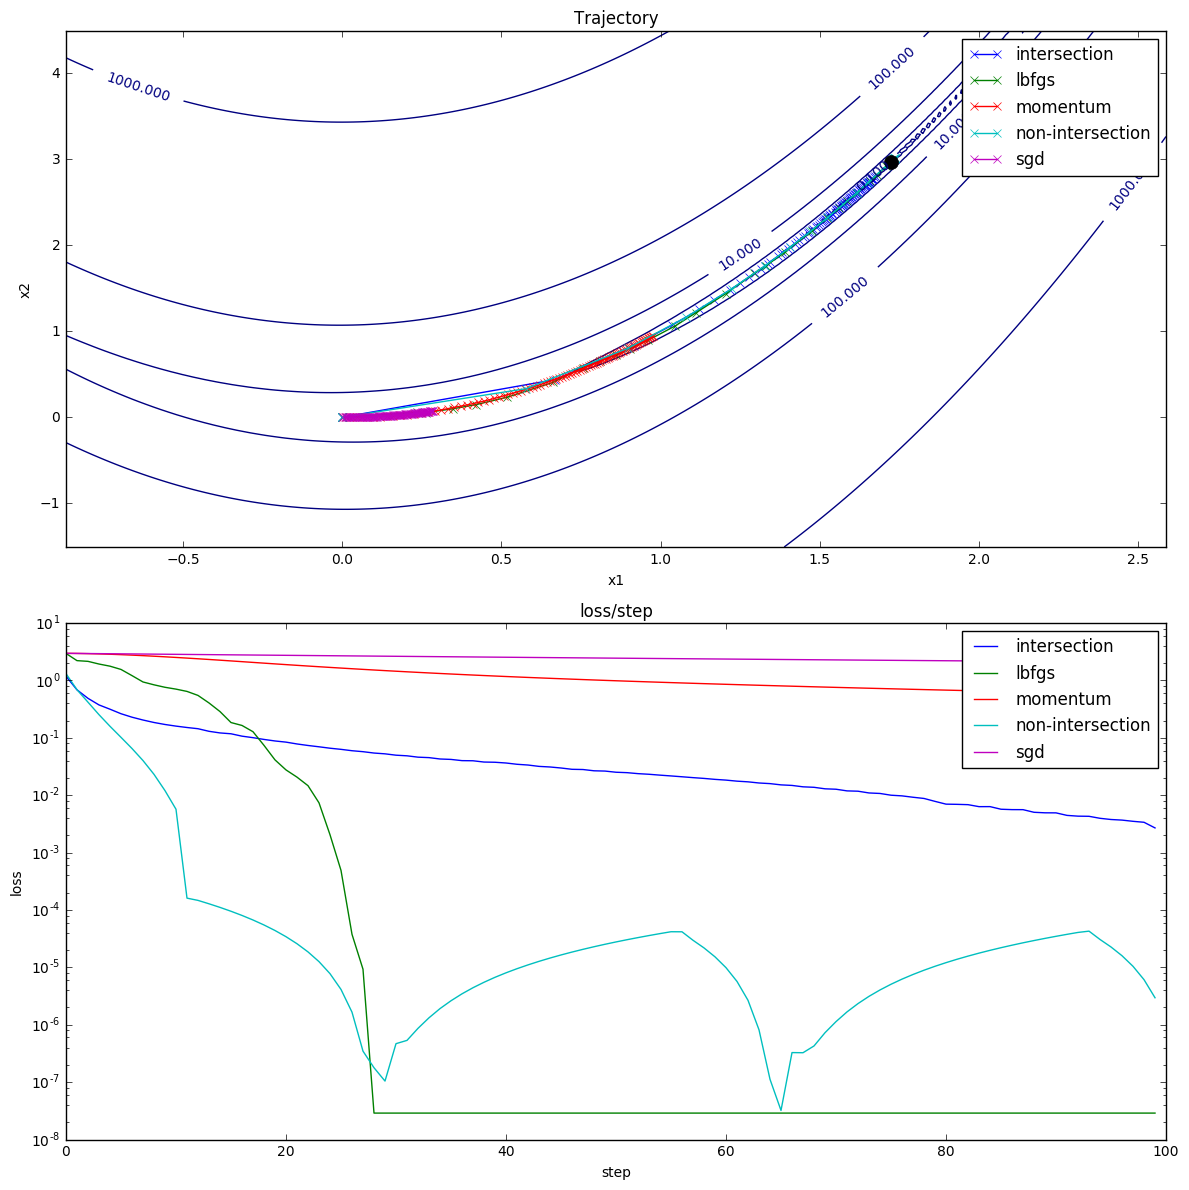

In [ ]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, non_lstm_optimizers)

(2.856475012945239, 8.159449499580504)


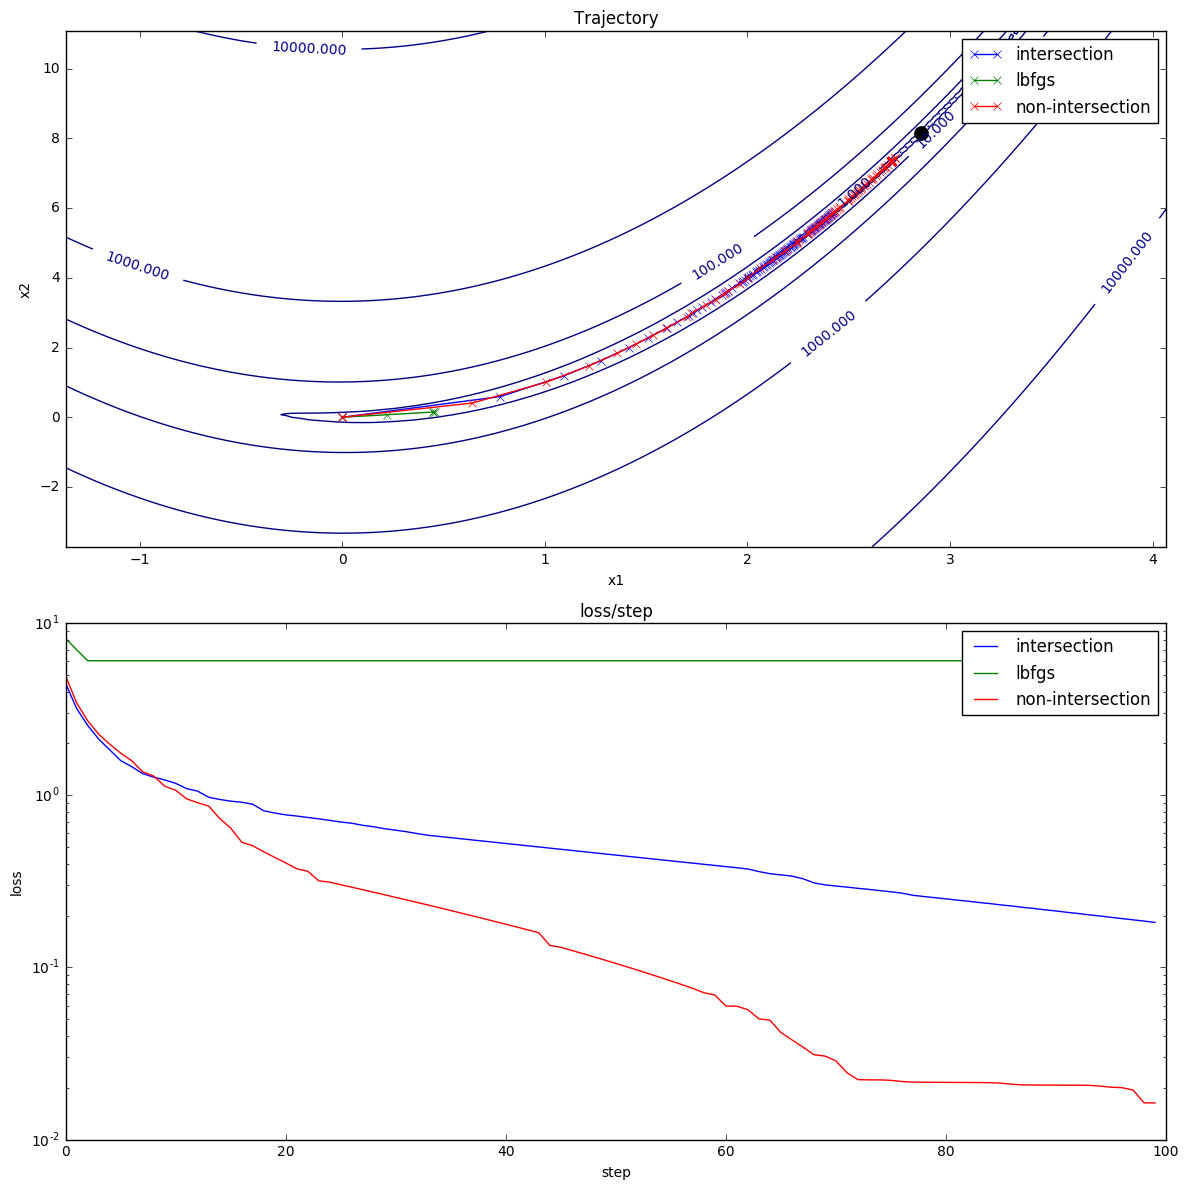

In [ ]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

(-2.405447888270187, 5.7861795431835015)


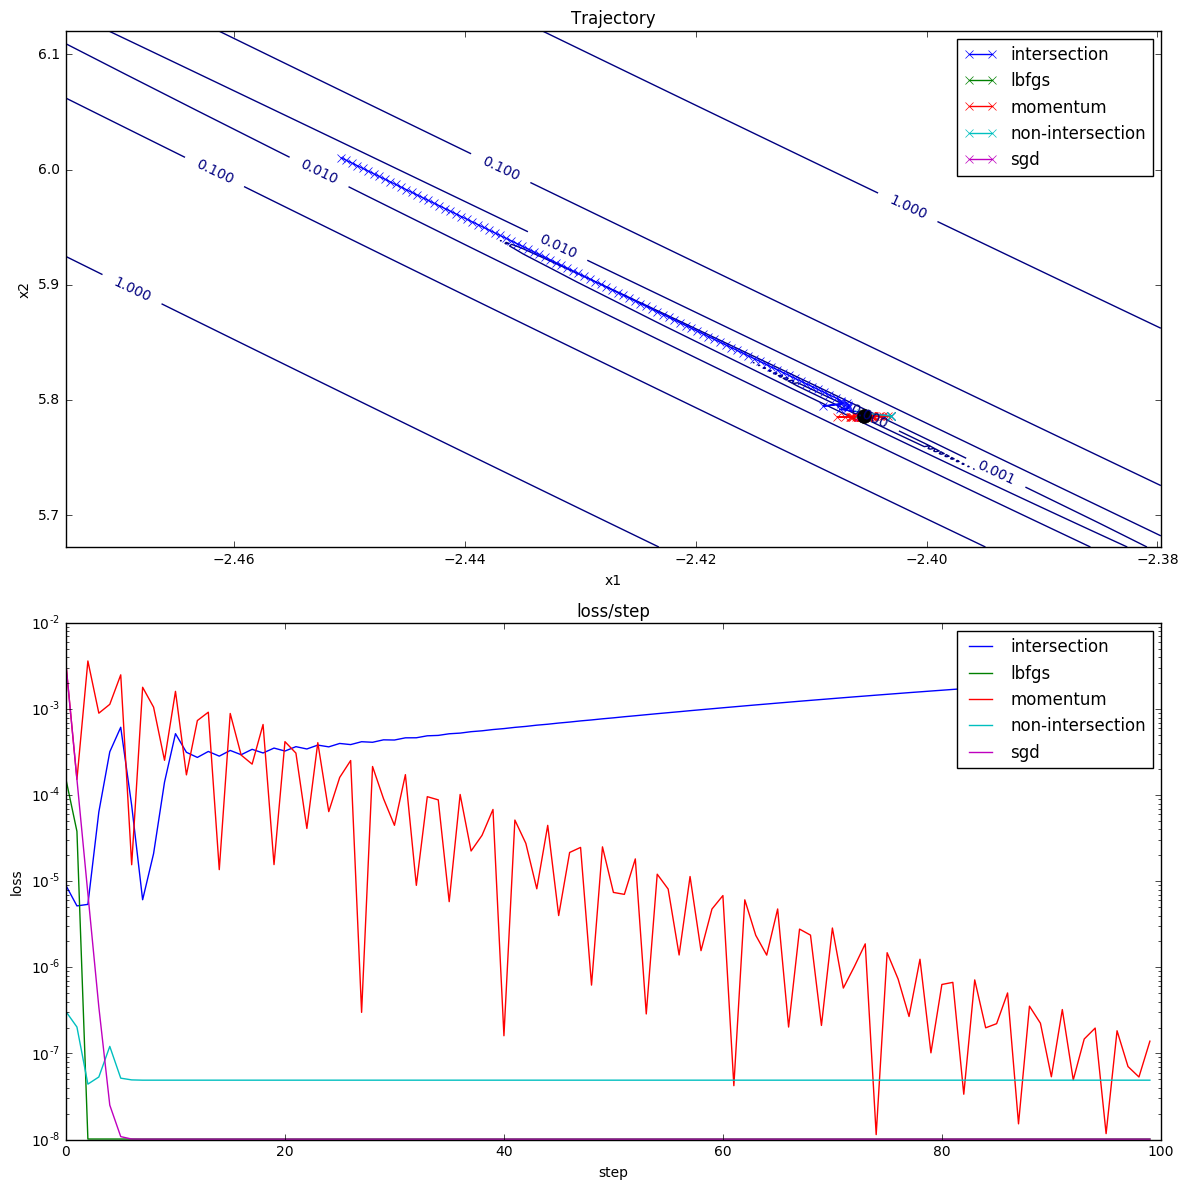

In [ ]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, non_lstm_optimizers)

(-1.3518325322345066, 1.8274511952075583)


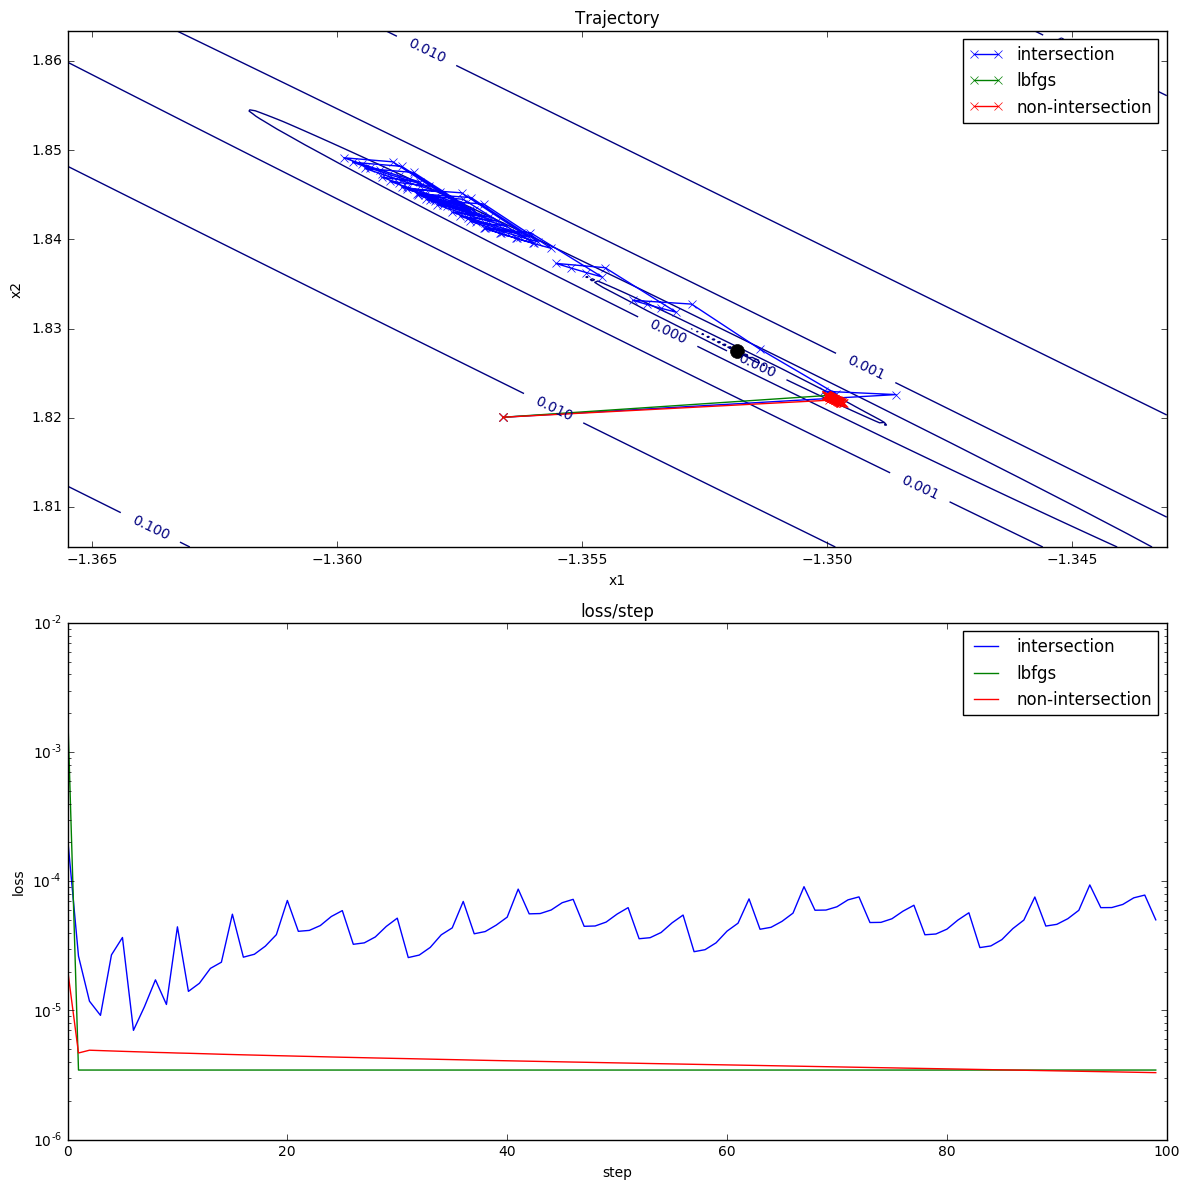

In [ ]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

In [ ]:
tests_results_2 = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : multisampler,
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results_2.append(histories)

Testing lstm; non-intersection
Testing lstm; intersection
Testing lbfgs
Testing momentum
Testing sgd
Testing lstm; non-intersection
Testing lstm; intersection
Testing lbfgs
Testing momentum
Testing sgd
Testing lstm; non-intersection
Testing lstm; intersection
Testing lbfgs
Testing momentum
Testing sgd
Testing lstm; non-intersection
Testing lstm; intersection


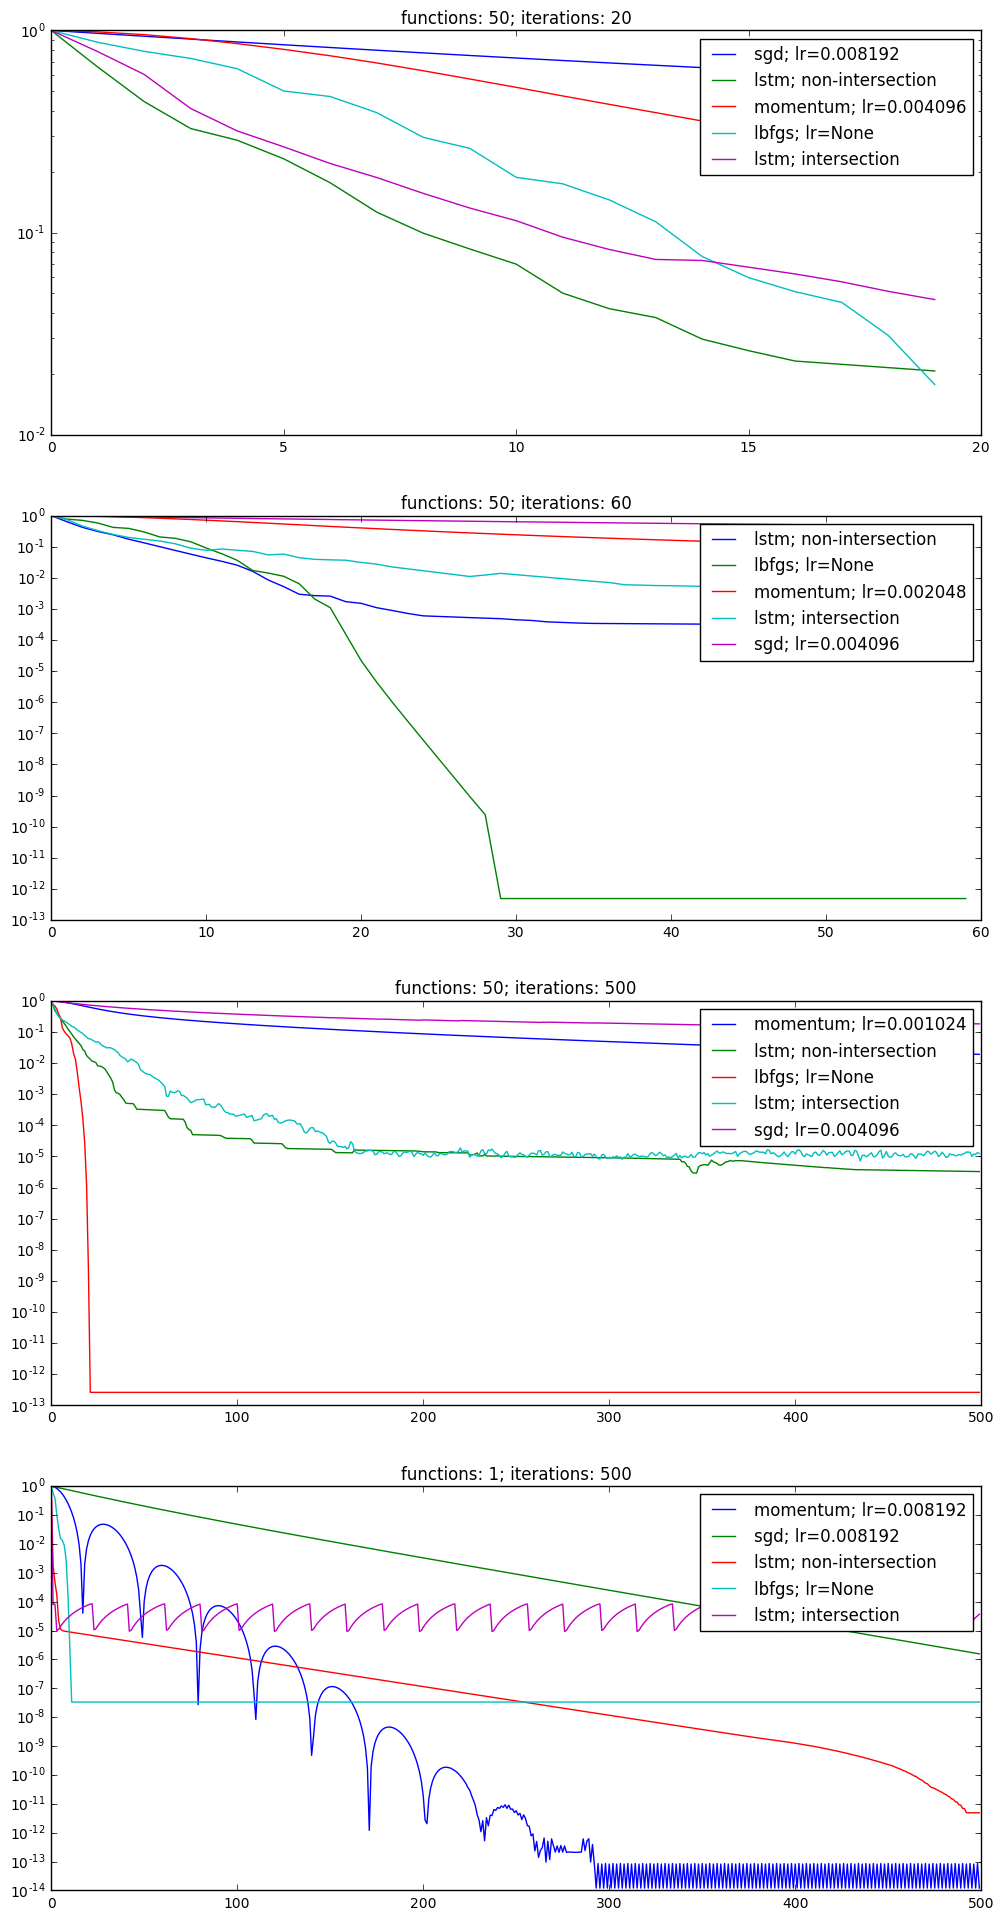

In [36]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results_2), figsize=(12, 6 * len(tests_results_2)))

if len(tests_results_2) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results_2):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()

In [48]:
def chain_optimize(self, theta, func_params, n_iter):
    theta_history = [theta]
    loss_history = []

    indexes = []
    
    for it in range(n_iter):
        thetas, losses = zip(*[opt.optimize(theta, func_params, self.n_small_steps) for opt in self.opts])

        thetas = np.concatenate([t.reshape(1, *t.shape) for t in thetas])
        losses = np.concatenate([l.reshape(1, *l.shape) for l in losses])

        best_opt_index = np.argmin(losses[:, :, -1], axis=0)
        indexes.append(best_opt_index)
        
        theta = thetas[best_opt_index, np.arange(thetas.shape[1]), -1]
        
        theta_history.append(theta)
        loss_history.append(losses[best_opt_index, np.arange(thetas.shape[1]), -1])

    self.indexes = indexes
        
    return np.array(theta_history).transpose(1, 0, 2), np.array(loss_history).T

In [49]:
ChainOptimizer.optimize_index = chain_optimize

In [65]:
t, a, b = multisampler(100)
th, lh = opt_intersection.optimize_index(t, [a, b], 500);

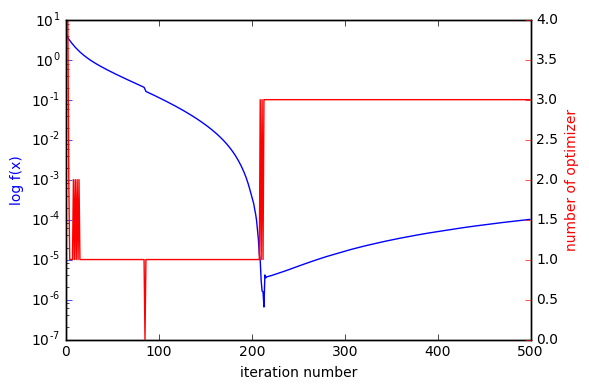

In [71]:
problem_number = 20

fig, ax1 = plt.subplots()
ax1.semilogy(lh[problem_number], color='b')
ax1.set_xlabel('iteration number')
ax1.set_ylabel('log f(x)', color='b')
ax1.tick_params('y', color='b')

ax2 = ax1.twinx()
ax2.plot(np.array(opt_intersection.indexes).T[problem_number], color='r')
ax2.set_ylabel('number of optimizer', color='r')
ax2.tick_params('y', color='r')

fig.tight_layout()

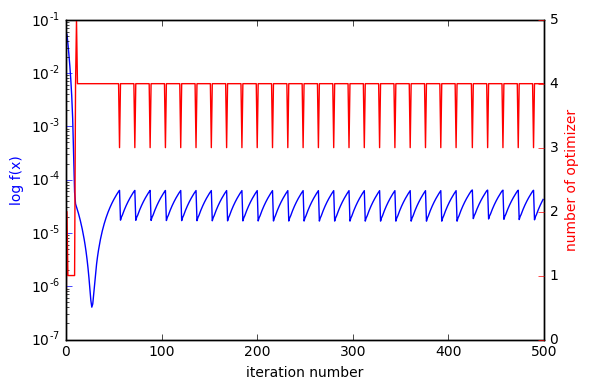

In [73]:
problem_number = 49

fig, ax1 = plt.subplots()
ax1.semilogy(lh[problem_number], color='b')
ax1.set_xlabel('iteration number')
ax1.set_ylabel('log f(x)', color='b')
ax1.tick_params('y', color='b')

ax2 = ax1.twinx()
ax2.plot(np.array(opt_intersection.indexes).T[problem_number], color='r')
ax2.set_ylabel('number of optimizer', color='r')
ax2.tick_params('y', color='r')

fig.tight_layout()